# Written for UVA Business Academy | Friday 5/24 | R - ArcGIS Bridge



### Key Takeaway: Spatial data is everywhere

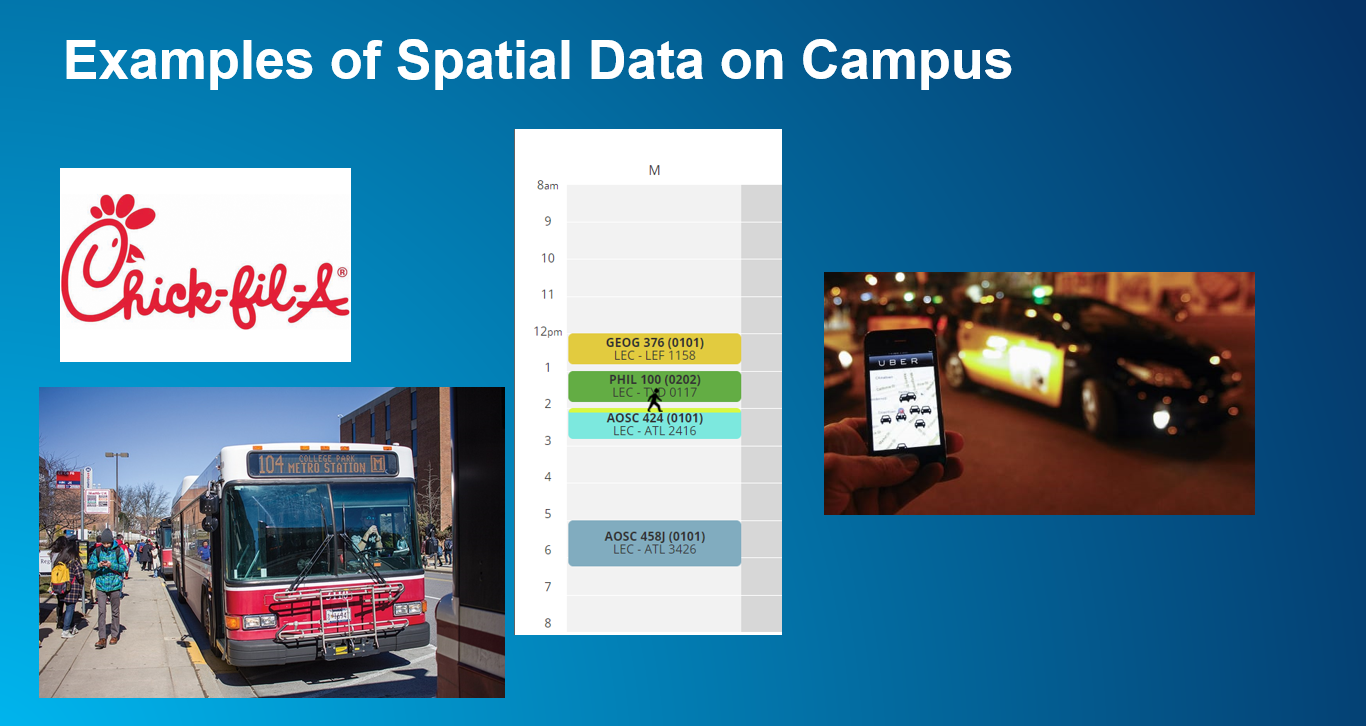

## The R-ArcGIS Bridge provides the ability to integrate R and ArcGIS functionality. 
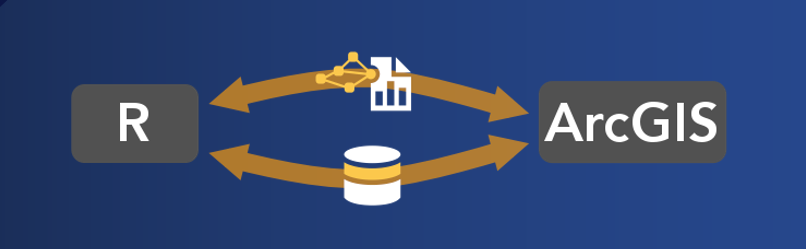


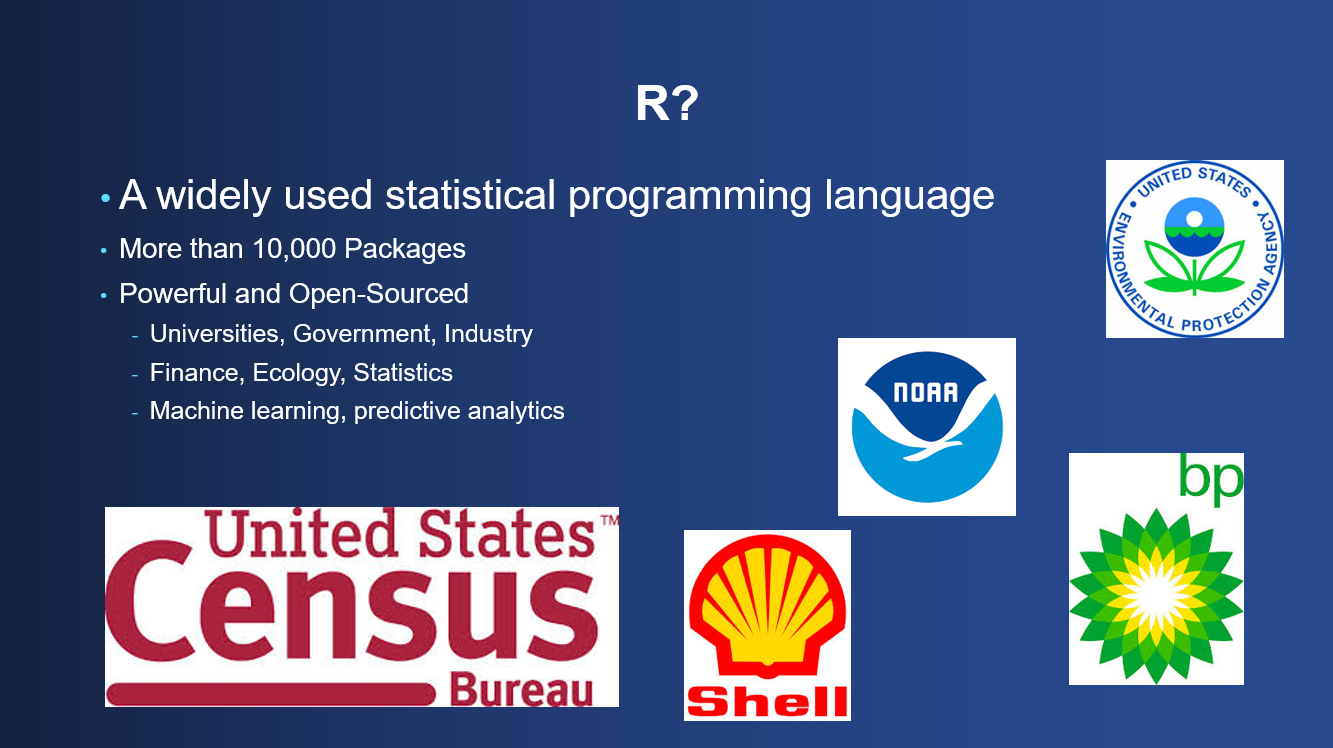


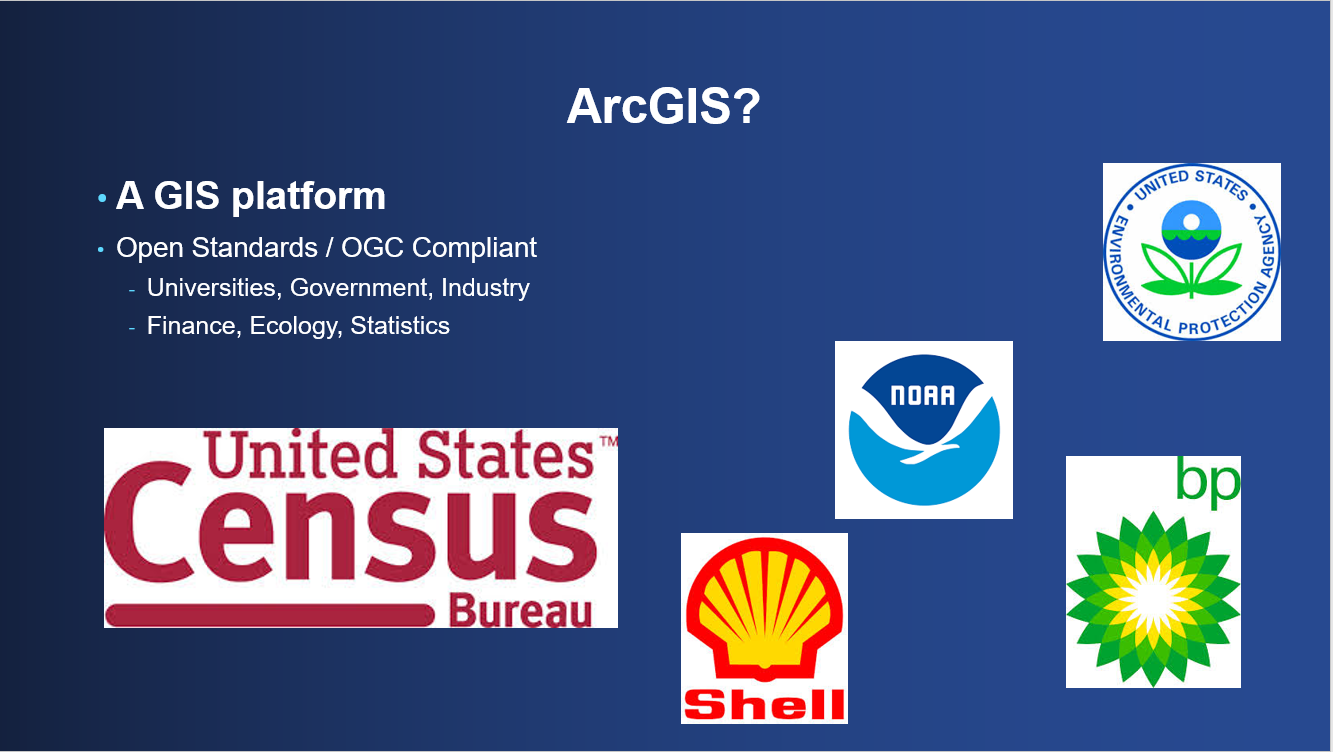

### This sample workflow explores the spatial and non-spatial relationships between College Campuses and Subway Restaurants

### Topics Covered: 
- Characteristics of Colleges/Universities with Subway Shops on Campus
- Which Colleges/Universities should open a campus Subway Shop?

### Data used: 
- Schools and Universities: http://esrifederal.maps.arcgis.com/home/item.html?id=6e22847e65c2449e8d6bc494e8f417e5
- Subway Locations: http://esrifederal.maps.arcgis.com/home/item.html?id=fda932197727499187e6f211f458434c


## Part 1 -- Find Data In ArcGIS Online --> Move to Desktop GIS Environment


### Data Cleaning In Desktop GIS:
- Filter Out Schools with < 1000 students
- School type limited to Universities, Colleges, and Junior Colleges

### Performing the Near  Geoprocessing Tool, calculates distances between each school and it's nearest Subway Restaurant  

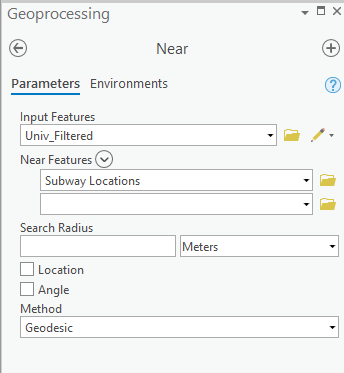

## Part 2. Loading the R - ArcGIS Bridge & other useful packages 

- Load the ArcGISBinding package which seamlessly transfers GIS workflows into R and vice versa 
<br>
- Dplyr /Reshape packages / data manipulation and exploratory data analysis 
<br>
- Ggplot2 gives provides highly customized graphics / plots / data visualization 
<br>
- Sp adds a spatial component to the R data frame 

In [1]:
#install.packages("dplyr")

library(ggplot2)
library(reshape2)
library(dplyr)
library(sp)
library(stringr)
library(arcgisbinding)


Warning message:
"package 'ggplot2' was built under R version 3.5.3"Warning message:
"package 'reshape2' was built under R version 3.5.2"Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'sp' was built under R version 3.5.3"Warning message:
"package 'stringr' was built under R version 3.5.3"*** Please call arc.check_product() to define a desktop license.


## Part 3. Moving the Refined Nearest Subway Chain Dataset from an ArcGIS Pro to a R Environment 


In [2]:
#Check ArcGIS Liciense 
arc.check_product()

product: ArcGIS Pro ( 12.4.0.19826 )
license: Advanced 
version: 1.0.1.232

In [3]:
#Read in Universities/ Nearest Dataset
universities_df <- arc.open("C:\\Users\\lu9739\\Documents\\ArcGIS\\Projects\\Chickfila_Colleges\\AnalysisWorkflow.gdb\\Nearest_Subway_Univ")

#Select Relevant Fields / convert to a R Dataframe 
selected_univ_df <- arc.select(object = universities_df, fields = c("Name", "Address", "City","State","Type", "Population", "NAICS_DESC", "SIZE_SET", "INST_SIZE", "PT_ENROLL", "FT_ENROLL", "TOT_ENROLL", "DORM_CAP", "TOT_EMPLOY", "NEAR_FID", "NEAR_DIST","Type"))

selected_univ_df[1:10,]

Name,Address,City,State,Type,Population,NAICS_DESC,SIZE_SET,INST_SIZE,PT_ENROLL,FT_ENROLL,TOT_ENROLL,DORM_CAP,TOT_EMPLOY,NEAR_FID,NEAR_DIST
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
College of The Sequoias,915 S Mooney Blvd,Visalia,CA,1,11713,Junior Colleges,4,4,6276,4798,11074,0,639,2197,929.9207
Worcester Polytechnic Institute,100 Institute Road,Worcester,MA,2,7023,"Colleges, Universities, and Professional Schools",14,3,1515,4442,5957,1590,1066,26289,458.9571
Frostburg State University,101 Braddock Road,Frostburg,MD,1,6409,"Colleges, Universities, and Professional Schools",13,3,904,4517,5421,1655,988,22564,414.3506
Columbia College,11600 Columbia College Dr,Sonora,CA,1,3280,Junior Colleges,2,2,2143,918,3061,0,219,7056,6041.5757
Allegany College of Maryland,12401 Willowbrook Rd Se,Cumberland,MD,1,4307,Junior Colleges,3,2,1639,1955,3594,236,713,22567,2546.7212
Towson University,8000 York Rd,Towson,MD,1,25168,"Colleges, Universities, and Professional Schools",16,5,4908,17052,21960,4567,3208,23188,539.7978
Florida Southern College,111 Lake Hollingsworth Dr,Lakeland,FL,2,3060,"Colleges, Universities, and Professional Schools",11,2,336,2115,2451,1526,609,9776,2060.8431
Goucher College,1021 Dulaney Valley Rd,Baltimore,MD,2,2831,"Colleges, Universities, and Professional Schools",11,2,623,1631,2254,1251,577,23190,735.0551
Polk State College,999 Avenue H Ne,Winter Haven,FL,1,12473,Junior Colleges,4,4,7424,3886,11310,0,1163,9744,2650.4883


## Part 4. Exploring our data / Detecting Spatial Trends / Plotting / Calculating General Statistics

Filter Out Online Colleges 
<br>

New Fields: 
- Distance in Kilometer Units 
<br>
- Obtains percentage Part time students 
<br>
- Student Assessibility (Distance < 1.5 km) |  Binary Value (yes/no) 

<b><h3>Using the dplyr library, a new field is created that converts meters to kilometers (to closest Subway chain). The percentage of part time students is also added as a field. </h3> </b>   

In this example, an easily assessible Subway should be within a 1.5 kilometer radius of Campus. Therefore, a new binary field (StudentAssessible) is added to our R dataframe. A value of 1 indicates that a Subway Chain is within 1.5 kilometers of Campus center, while 0 indicates that there are no assessible subway restuarants. 

In [4]:
library(dplyr)

selected_univ_df <- selected_univ_df %>%
  mutate(RateKm = (selected_univ_df$NEAR_DIST / 1000 )) %>%
  mutate(PercentPartTime = ((selected_univ_df$PT_ENROLL / selected_univ_df$TOT_ENROLL) * 100)) %>%
  mutate(StudentAssessible = ifelse(NEAR_DIST <= 1207, 1, 0)) %>%
  filter(!selected_univ_df$Name %in% "Online") %>%
  filter(Type != 3)


In [5]:
head(selected_univ_df)

Name,Address,City,State,Type,Population,NAICS_DESC,SIZE_SET,INST_SIZE,PT_ENROLL,FT_ENROLL,TOT_ENROLL,DORM_CAP,TOT_EMPLOY,NEAR_FID,NEAR_DIST,RateKm,PercentPartTime,StudentAssessible
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
College of The Sequoias,915 S Mooney Blvd,Visalia,CA,1,11713,Junior Colleges,4,4,6276,4798,11074,0,639,2197,929.9207,0.9299207,56.67329,1
Worcester Polytechnic Institute,100 Institute Road,Worcester,MA,2,7023,"Colleges, Universities, and Professional Schools",14,3,1515,4442,5957,1590,1066,26289,458.9571,0.4589571,25.43226,1
Frostburg State University,101 Braddock Road,Frostburg,MD,1,6409,"Colleges, Universities, and Professional Schools",13,3,904,4517,5421,1655,988,22564,414.3506,0.4143506,16.67589,1
Columbia College,11600 Columbia College Dr,Sonora,CA,1,3280,Junior Colleges,2,2,2143,918,3061,0,219,7056,6041.5757,6.0415757,70.00980,0
Allegany College of Maryland,12401 Willowbrook Rd Se,Cumberland,MD,1,4307,Junior Colleges,3,2,1639,1955,3594,236,713,22567,2546.7212,2.5467212,45.60378,0
Towson University,8000 York Rd,Towson,MD,1,25168,"Colleges, Universities, and Professional Schools",16,5,4908,17052,21960,4567,3208,23188,539.7978,0.5397978,22.34973,1


### Generating General Descriptive Statistics about the data (How each field is distributed)
- Mean, Median, Min, Max for each field 

In [6]:
sum1 <- summary(selected_univ_df)
sum1

     Name             Address              City              State          
 Length:2556        Length:2556        Length:2556        Length:2556       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     Type             Population      NAICS_DESC          SIZE_SET        
 Length:2556        Min.   :  1001   Length:2556        Length:2556       
 Class :character   1st Qu.:  2414   Class :character   Class :character  
 Mode  :character   Median :  4576   Mode  :character   Mode  :character  
                    Mean   :  8535                                        
                    3rd Qu.: 10094                                        
           

<b><h3> Using the data visualization package, ggplot2 to breakdown the proximity of College/University campuses with its nearest Subway. This histogram indicates that an majority of College Campuses are within a 1.5 kilometer distance of a Subway chain. </b></h3>  

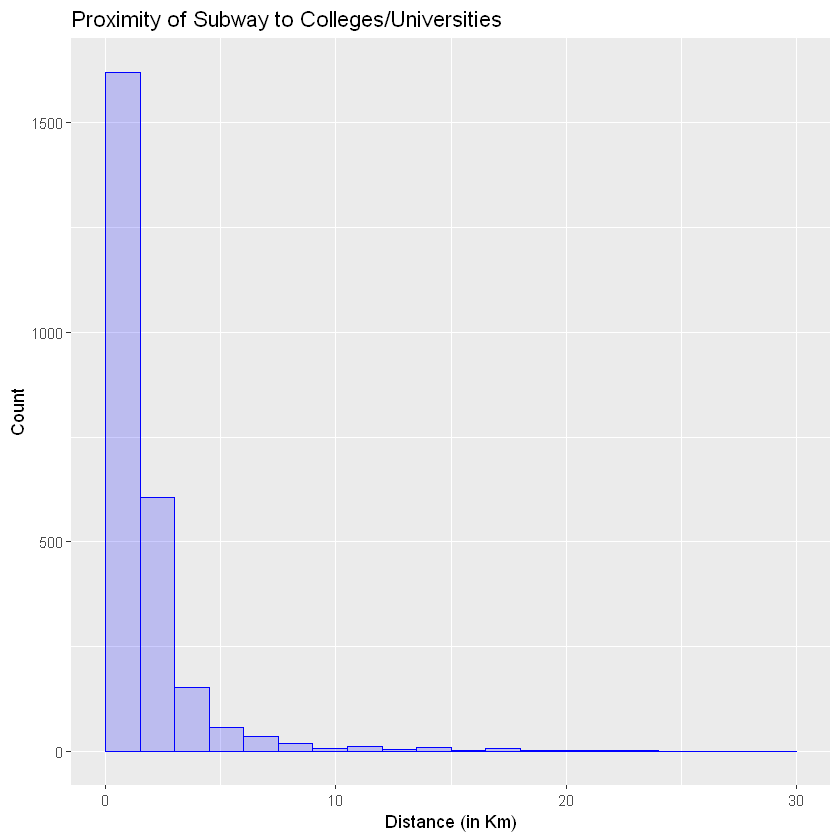

In [7]:
library(ggplot2)

ggplot(data = selected_univ_df, aes(selected_univ_df$RateKm))+
  geom_histogram(breaks=seq(0, 30, by =1.5), col = "blue",fill = "blue", alpha = 0.2)+
  labs(title="Proximity of Subway to Colleges/Universities") +
  labs(x="Distance (in Km)", y="Count")

<b><h3>Almost all large schools (with over 25,000 total enrollment) has an easily accessible Subway shop</b></h3>

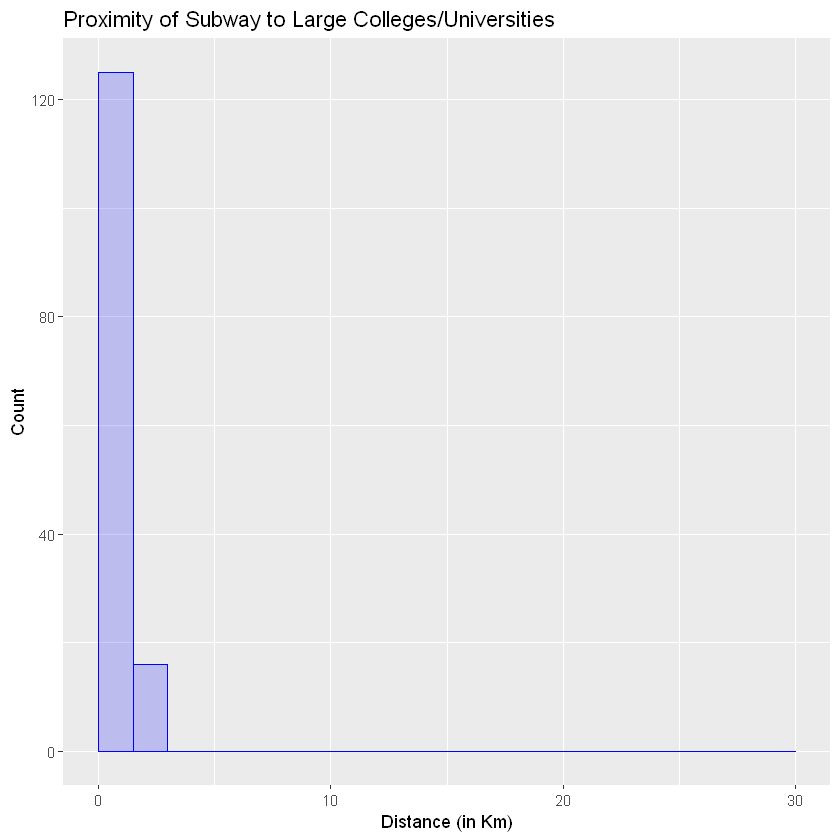

In [8]:
#Histogram of Subway Proximity for large campuses (Population > 25,000)
big_schools_df <- filter(selected_univ_df, TOT_ENROLL >= 25000)
ggplot(data = big_schools_df, aes(big_schools_df$RateKm))+
  geom_histogram(breaks=seq(0,30, by =1.5), col = "blue",fill = "blue", alpha = 0.2)+
  labs(title="Proximity of Subway to Large Colleges/Universities") +
  labs(x="Distance (in Km)", y="Count")


### Using a correlation matrix, we can select and visualize variables that might correlate with the distance to a Subway chain.

#### Here are some University factors that may impact the distance between a university and it's closest Subway:
- Total Population
- Number of Full Time Students
- Number of Dorm Rooms
- Percent of Students that enroll part time

,RateKm,Population,FT_ENROLL,DORM_CAP,PercentPartTime
RateKm,1.0000000,-0.2876595,-0.3074272,-0.1494731,0.1015505
Population,-0.2876595,1.0000000,0.9109755,0.1972835,0.2222320
FT_ENROLL,-0.3074272,0.9109755,1.0000000,0.4398609,-0.1160935
DORM_CAP,-0.1494731,0.1972835,0.4398609,1.0000000,-0.6864915
PercentPartTime,0.1015505,0.2222320,-0.1160935,-0.6864915,1.0000000


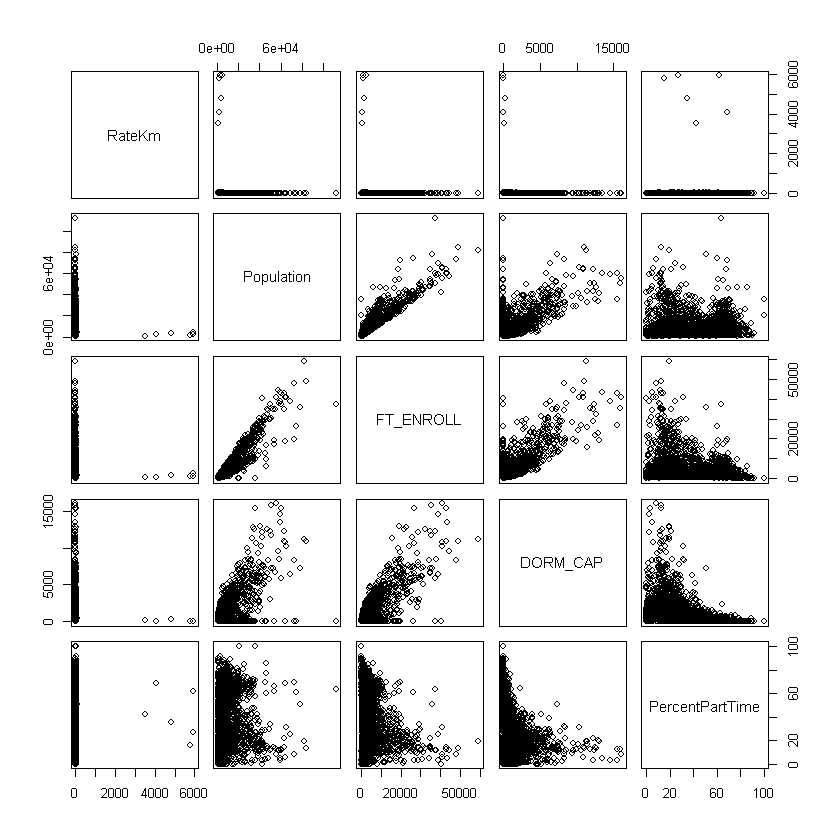

In [9]:
#Create a correlation matrix############################################
library(reshape2)
corr_data <- selected_univ_df[, c(17,6,11,13,18)]
plot(corr_data)


corr_matrix <- cor((corr_data), use = "everything", method = "spearman")
corr_matrix

#Filters out upper half of matrix 
get_lower_tri<-function(corr_matrix){
  corr_matrix[lower.tri(corr_matrix)] <- NA
  return(corr_matrix)
}

lower_matrix <- get_lower_tri(corr_matrix)

melted_matrix <- melt(lower_matrix, na.rm = TRUE)

correlation_matrix <- ggplot(data = melted_matrix, aes(Var2, Var1, fill = value))+
  geom_tile(color = "white")+
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1,1), space = "Lab", 
                       name="Spearman\nCorrelation") +
  theme_minimal()+ 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                   size = 12, hjust = 1))+
  coord_fixed()


matrix_plot <- correlation_matrix + 
  geom_text(aes(Var2, Var1, label = round(value, digits = 2)
  ), color = "black", size = 4) +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid.major = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank(),
    axis.ticks = element_blank(),
    legend.justification = c(1, 0),
    legend.position = c(0.6, 0.7),
    legend.direction = "horizontal")+
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                               title.position = "top", title.hjust = 0.5))+
  ggtitle("Vacancy Rate Correlation Matrix")

#### Based on this correlation matrix:
- Higher population slightly results in closer Subway Chain
- Higher number of full time students slightly results in closer Subway Chain
- Increased Dorm Rooms results in lower percentage of part time enrollment

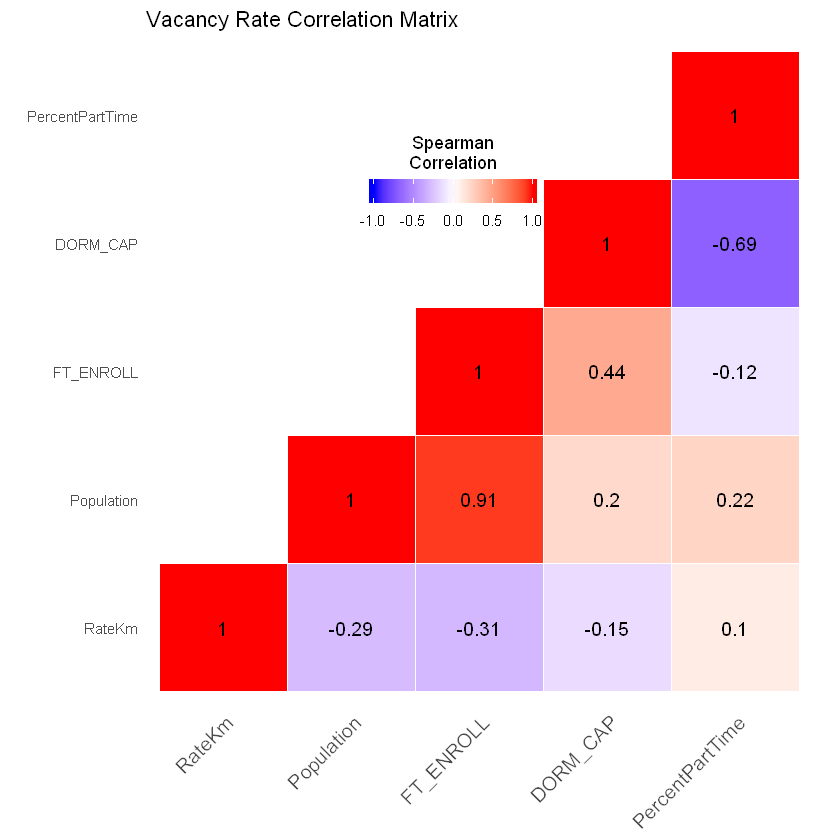

In [10]:
matrix_plot

## Part 5.  Building a Logistic Regression Model to determine which schools should open a more accessible Subway

### Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary). 
- How does the probability of getting lung cancer (yes vs. no) change for every additional pound a person is overweight and for every pack of cigarettes smoked per day?

### For this Logistic Regression model, the binary Student Assessibility field will be the depedent variable (0 for no accessible Subway / 1 for accessible subway). The following explanatory indepedent variables will be used to explain changes in the depedent variable (Student Assessibility) 
- Number of full time students 
- Total enrollment
- Dorm capacity
- Total University Employees
- Percent of students that are enrolled part time
- School type (College vs. Jr.College)


In [11]:
# Executive the logistic model 
univ_logit <- glm(StudentAssessible ~ FT_ENROLL + TOT_ENROLL + DORM_CAP + TOT_EMPLOY + PercentPartTime + NAICS_DESC, data = selected_univ_df, family = "binomial")
summary(univ_logit)

# Obtain confidence interval for coefficient estimates
confint(univ_logit)



Call:
glm(formula = StudentAssessible ~ FT_ENROLL + TOT_ENROLL + DORM_CAP + 
    TOT_EMPLOY + PercentPartTime + NAICS_DESC, family = "binomial", 
    data = selected_univ_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0882  -1.1513   0.4013   1.1420   1.5347  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -5.313e-02  1.062e-01  -0.500  0.61684    
FT_ENROLL                  8.512e-05  4.043e-05   2.106  0.03524 *  
TOT_ENROLL                 3.328e-05  2.021e-05   1.647  0.09954 .  
DORM_CAP                  -1.820e-04  5.941e-05  -3.063  0.00219 ** 
TOT_EMPLOY                 1.376e-04  5.047e-05   2.725  0.00643 ** 
PercentPartTime           -1.862e-03  3.006e-03  -0.619  0.53571    
NAICS_DESCJunior Colleges -6.603e-01  1.246e-01  -5.301 1.15e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-2.622154e-01,1.542187e-01
FT_ENROLL,6.039504e-06,1.645761e-04
TOT_ENROLL,-5.556136e-06,7.377293e-05
DORM_CAP,-2.985359e-04,-6.546337e-05
TOT_EMPLOY,4.706887e-05,2.457373e-04
PercentPartTime,-7.763890e-03,4.026752e-03
NAICS_DESCJunior Colleges,-9.053677e-01,-4.169043e-01


<b><h3>Here is the outputs of the model which outputs the coefficient, p value, z value, and the confidence variable for each predictor field.
    <br></h3>
The logistic regression coefficients give the change in the log odds of the outcome for a one unit increase in the predictor variable.
<br> 
</b>
<h2><b>
    Using the coefficients of the output model, we can calculate the Predicted Probabilities (of an Accessible Subway (< 1.5 km)) for each campus. 
</h2></b>    

In [12]:
#Calculating the predicted probability 
predicted_prob_univ <- cbind(selected_univ_df, predict(univ_logit, newdata = selected_univ_df, type = "link",
                                    se = TRUE))
predicted_prob_univ <- within(predicted_prob_univ, {
  PredictedProb <- plogis(fit)
  LL <- plogis(fit - (1.96 * se.fit))
  UL <- plogis(fit + (1.96 * se.fit))
})




### Here is the calculated Predicted Probabilities (of an Accessible Subway Shops) for every Maryland School. 

#### Schools with high PredictedProb values usually has an accessible Subway chain (StudentAssessible value of 1). 

In [13]:
# Predicted Probabilities for colleges in Maryland
predicted_prob_univ[with(predicted_prob_univ, order(-PredictedProb)), ] %>% 
    select("Name","State" ,"FT_ENROLL", "DORM_CAP","PredictedProb","StudentAssessible") %>%
    filter(str_detect(State, 'MD'))
           

Name,State,FT_ENROLL,DORM_CAP,PredictedProb,StudentAssessible
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
Johns Hopkins University,MD,13521,2680,0.9766707,1
University of Maryland-College Park,MD,32274,12571,0.9501085,1
University of Maryland-University College,MD,6141,0,0.9055915,1
Towson University,MD,17052,4567,0.8452324,1
University of Maryland-Baltimore,MD,5103,513,0.8125488,1
Montgomery College,MD,9888,0,0.7958144,1
The Community College of Baltimore County,MD,8373,0,0.7479733,1
University of Maryland-Baltimore County,MD,10505,3855,0.7005720,1
Salisbury University,MD,7611,2071,0.6716107,1


## Which Colleges/Universities should in on-campus a Subway Shop?

### Based on the results of the Logistic Regression Model, here is a of Colleges/Universities that should open a more assessible Subway location that is closer to campus. 

In [14]:
# Where Subway Should add restaurants 
add_subway <- predicted_prob_univ[with(predicted_prob_univ, order(-PredictedProb)), ] %>% 
    select("Name","State" ,"FT_ENROLL", "DORM_CAP","PredictedProb","StudentAssessible") %>%
    filter(StudentAssessible == 0)
    
add_subway <- add_subway %>%
    slice(1:20)

add_subway

Name,State,FT_ENROLL,DORM_CAP,PredictedProb,StudentAssessible
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
Liberty University,VA,35969,7265,0.9915056,0
University of California-Davis,CA,30870,6053,0.9870173,0
University of Georgia,GA,31117,7374,0.9771372,0
Northern Virginia Community College,VA,19388,0,0.9543315,0
University of Kansas,KS,23066,5332,0.9506538,0
Valencia College,FL,16955,0,0.9239198,0
University of Oklahoma Norman Campus,OK,21227,5848,0.9118849,0
University of Medicine and Dentistry of New Jersey,NJ,4610,462,0.9104183,0
Emory University,GA,13061,4464,0.9079791,0


## Part 6.  To conduct further analysis using various geoprocessing tools / workflows, we can bring our data back to an ArcGIS Pro Environment

In [15]:
library(sp)
selected_univ_sp <- arc.data2sp(selected_univ_df)
selected_univ_sp@data <- cbind(selected_univ_sp@data, predicted_prob_univ)
selected_univ_sp@data


#arc.write("C:\\Users\\lu9739\\Documents\\ArcGIS\\Projects\\Chickfila_colleges\\AnalysisWorkflow.gdb\\Nearest_Subway_Univ\\OutputResults", selected_univ_sp)


Name,Address,City,State,Type,Population,NAICS_DESC,SIZE_SET,INST_SIZE,PT_ENROLL,...,NEAR_DIST,RateKm,PercentPartTime,StudentAssessible,fit,se.fit,residual.scale,UL,LL,PredictedProb
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
College of The Sequoias,915 S Mooney Blvd,Visalia,CA,1,11713,Junior Colleges,4,4,6276,...,929.9207,0.9299207,56.673289,1,0.045909123,0.08015019,1,0.5505773,0.4722323,0.5114753
Worcester Polytechnic Institute,100 Institute Road,Worcester,MA,2,7023,"Colleges, Universities, and Professional Schools",14,3,1515,...,458.9571,0.4589571,25.432265,1,0.333140872,0.05536261,1,0.6086525,0.5559226,0.5825234
Frostburg State University,101 Braddock Road,Frostburg,MD,1,6409,"Colleges, Universities, and Professional Schools",13,3,904,...,414.3506,0.4143506,16.675890,1,0.315430640,0.05778747,1,0.6055618,0.5503704,0.5782103
Columbia College,11600 Columbia College Dr,Sonora,CA,1,3280,Junior Colleges,2,2,2143,...,6041.5757,6.0415757,70.009801,0,-0.633643621,0.09085474,1,0.3880377,0.3075243,0.3466848
Allegany College of Maryland,12401 Willowbrook Rd Se,Cumberland,MD,1,4307,Junior Colleges,3,2,1639,...,2546.7212,2.5467212,45.603784,0,-0.457195225,0.07744150,1,0.4242355,0.3522918,0.3876514
Towson University,8000 York Rd,Towson,MD,1,25168,"Colleges, Universities, and Professional Schools",16,5,4908,...,539.7978,0.5397978,22.349727,1,1.697686745,0.18060633,1,0.8861168,0.7930975,0.8452324
Florida Southern College,111 Lake Hollingsworth Dr,Lakeland,FL,2,3060,"Colleges, Universities, and Professional Schools",11,2,336,...,2060.8431,2.0608431,13.708690,0,-0.011001633,0.06701354,1,0.5300500,0.4644729,0.4972496
Goucher College,1021 Dulaney Valley Rd,Baltimore,MD,2,2831,"Colleges, Universities, and Professional Schools",11,2,623,...,735.0551,0.7350551,27.639752,1,-0.039048250,0.06402710,1,0.5215978,0.4589572,0.4902392
Polk State College,999 Avenue H Ne,Winter Haven,FL,1,12473,Junior Colleges,4,4,7424,...,2650.4883,2.6504883,65.641026,0,0.031515089,0.08087295,1,0.5473641,0.4682936,0.5078781
